# Outline

In this notebook I search for the best approach to fine tune `Ultralitics YOLOv8` to solve the competition.

# Installations

In [ ]:
!pip install ultralytics==8.0.20
!pip install roboflow==0.2.31

# Imports

In [1]:
import torch
import cv2
import locale
import os
import ultralytics
import pandas as pd
import numpy as np

from google.colab import drive
from IPython.display import display, Image
from PIL import Image
from roboflow import Roboflow
from ultralytics import YOLO
from methods import initialize_inception_model, predict_sample
from torchvision import transforms
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

SEED = 42
np.random.seed(SEED)
# random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.8/78.2 GB disk)


# Data

I uploded the data to the `roboflow` and exported it in `YOLO8` format.

Also I tried to expand dataset using [Stable Diffusion](https://stablediffusionweb.com/#demo) website. [I generated 65 more images](https://drive.google.com/drive/folders/1c1XLbw4x_rzCpegpHfJOVREq1A2FSXd8?usp=sharing) of brown bears and [marked them up manually on Roboflow](https://universe.roboflow.com/aml-92lrc/bears-8v0yh/dataset). Generated images are similar to those that we have in the original data _(bear with white hare, bear in the city, bear on the tree, bear in winter forest, bear under sky full of stars, bear in the mud, bear near the water and so on)_. I didn't use odinary images because they are very different in comparison to stable diffusion ones, so they are from different distributions.

I used horizontal clip and 20% crop as data augmentations to expand training data.

Also I tried to generate new sample via neural style transfer but it failed.

I have three versions of the dataset. 
1. Is just original training data uploaded to RoboFlow with applied augmentations and train-valid-test split. I used it for the first exeperiments to check whether YOLOv8 will work well on this task.

2. At the second version I added my own generated images and kept train-valid-test split. I used this version for condacting all my experiments.

3. In third version I redistributed test samples to the training part and used thi dataset for final training of the best solution on the whole data.

In [4]:
drive.mount('/content/drive')

!mkdir ./datasets
%cd ./datasets


# Load 2-nd version of the dataset for experiments.
rf = Roboflow(api_key="SeScyFeiR90djceO280o")
project = rf.workspace("aml-92lrc").project("bears-8v0yh")
dataset = project.version(2).download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Bears-2 in yolov8:: 100%|██████████| 2034/2034 [00:00<00:00, 2062.24it/s]


# Yolo8

Let's take a look at pretrained `Yolo8` model.

In [ ]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='/content/Bears-1/train/images/image_173_png.rf.d61f690e5e99c78948a3794f99e2f6a8.jpg' save=True

100% 6.23M/6.23M [00:00<00:00, 75.1MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CPU
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/Bears-1/train/images/image_173_png.rf.d61f690e5e99c78948a3794f99e2f6a8.jpg: 640x640 1 sheep, 1 bear, 562.2ms
Speed: 10.7ms pre-process, 562.2ms inference, 31.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


As we can see it is already good at bear recognition but has problems with hares generated by **Stable Diffusion**.

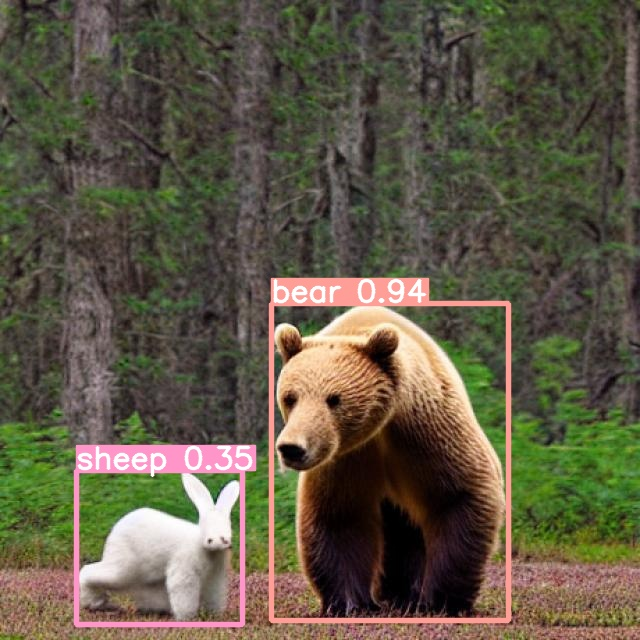

In [ ]:
Image(filename='/content/runs/detect/predict/image_173_png.rf.d61f690e5e99c78948a3794f99e2f6a8.jpg', height=600)

# Model Training

The design of the code architecture implies reusage of the implemented methods to dynamicly reconfigure experiment set-ups. The following cells show sample usage of those methods.

In [5]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=30 imgsz=800 plots=True

100% 21.5M/21.5M [00:01<00:00, 22.3MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/Bears-2/data.yaml, epochs=30, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=F

# Model evaluation

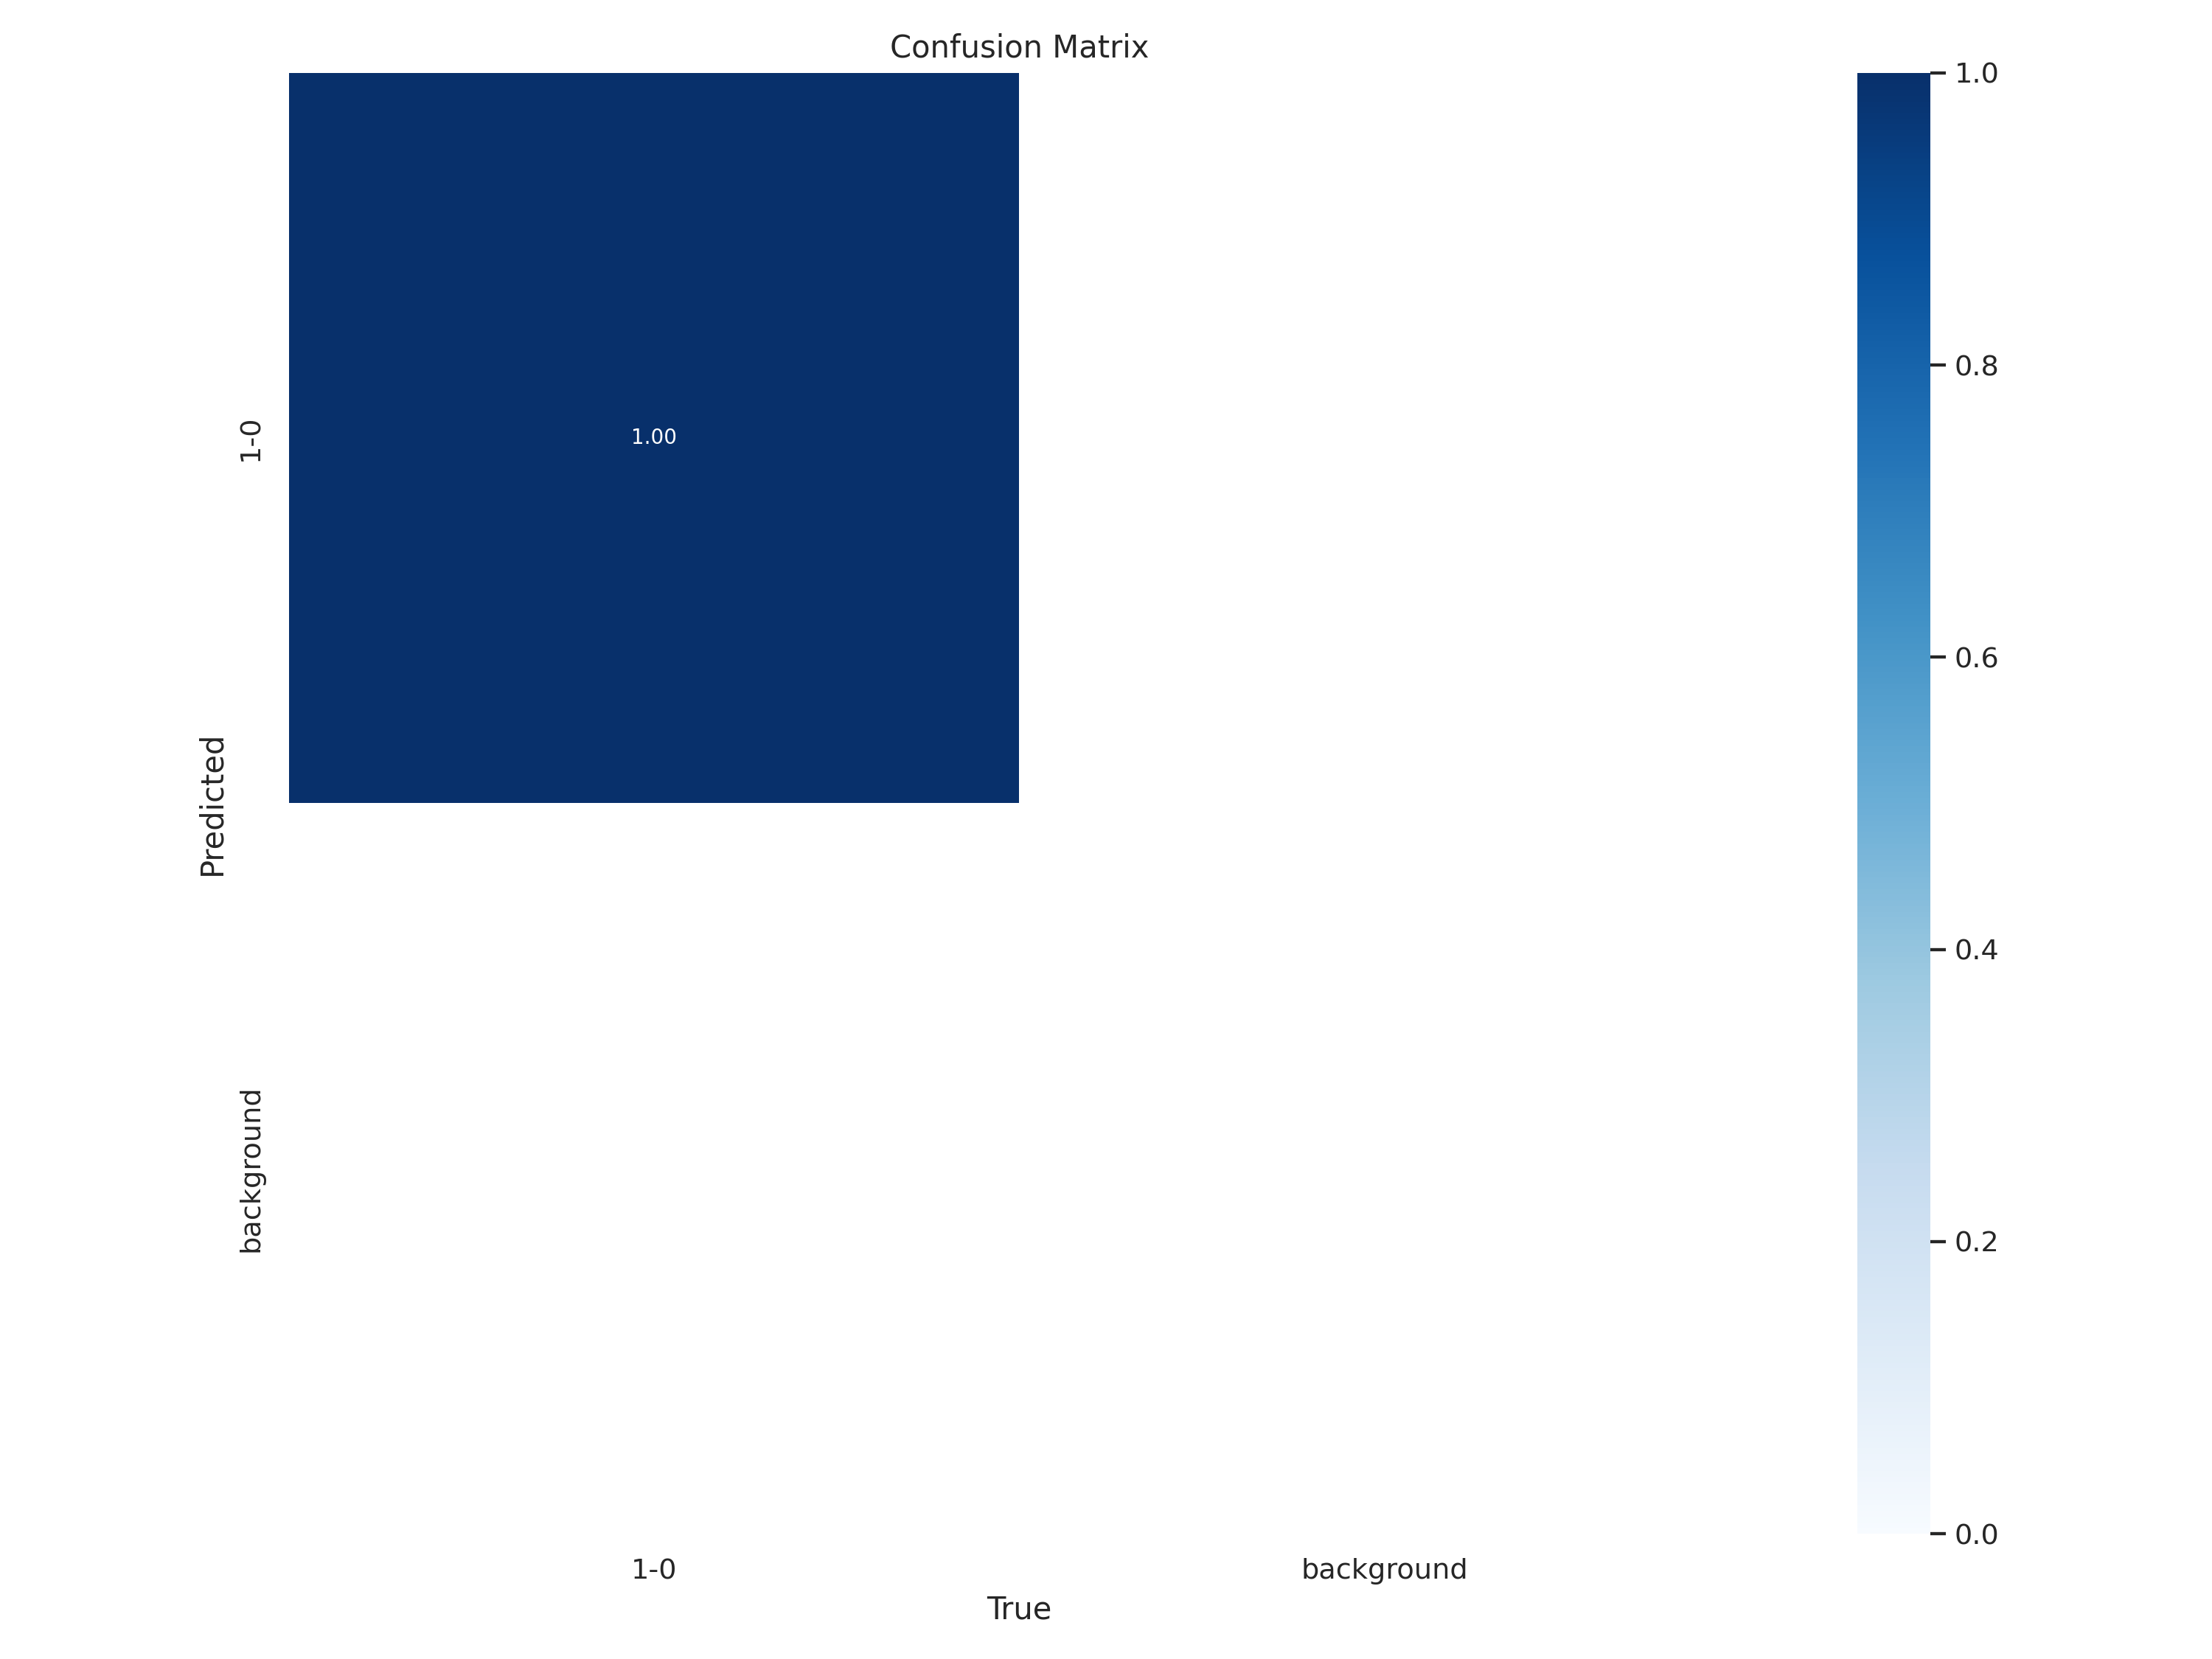

In [7]:
Image(filename=f'./runs/detect/train/confusion_matrix.png', width=600)

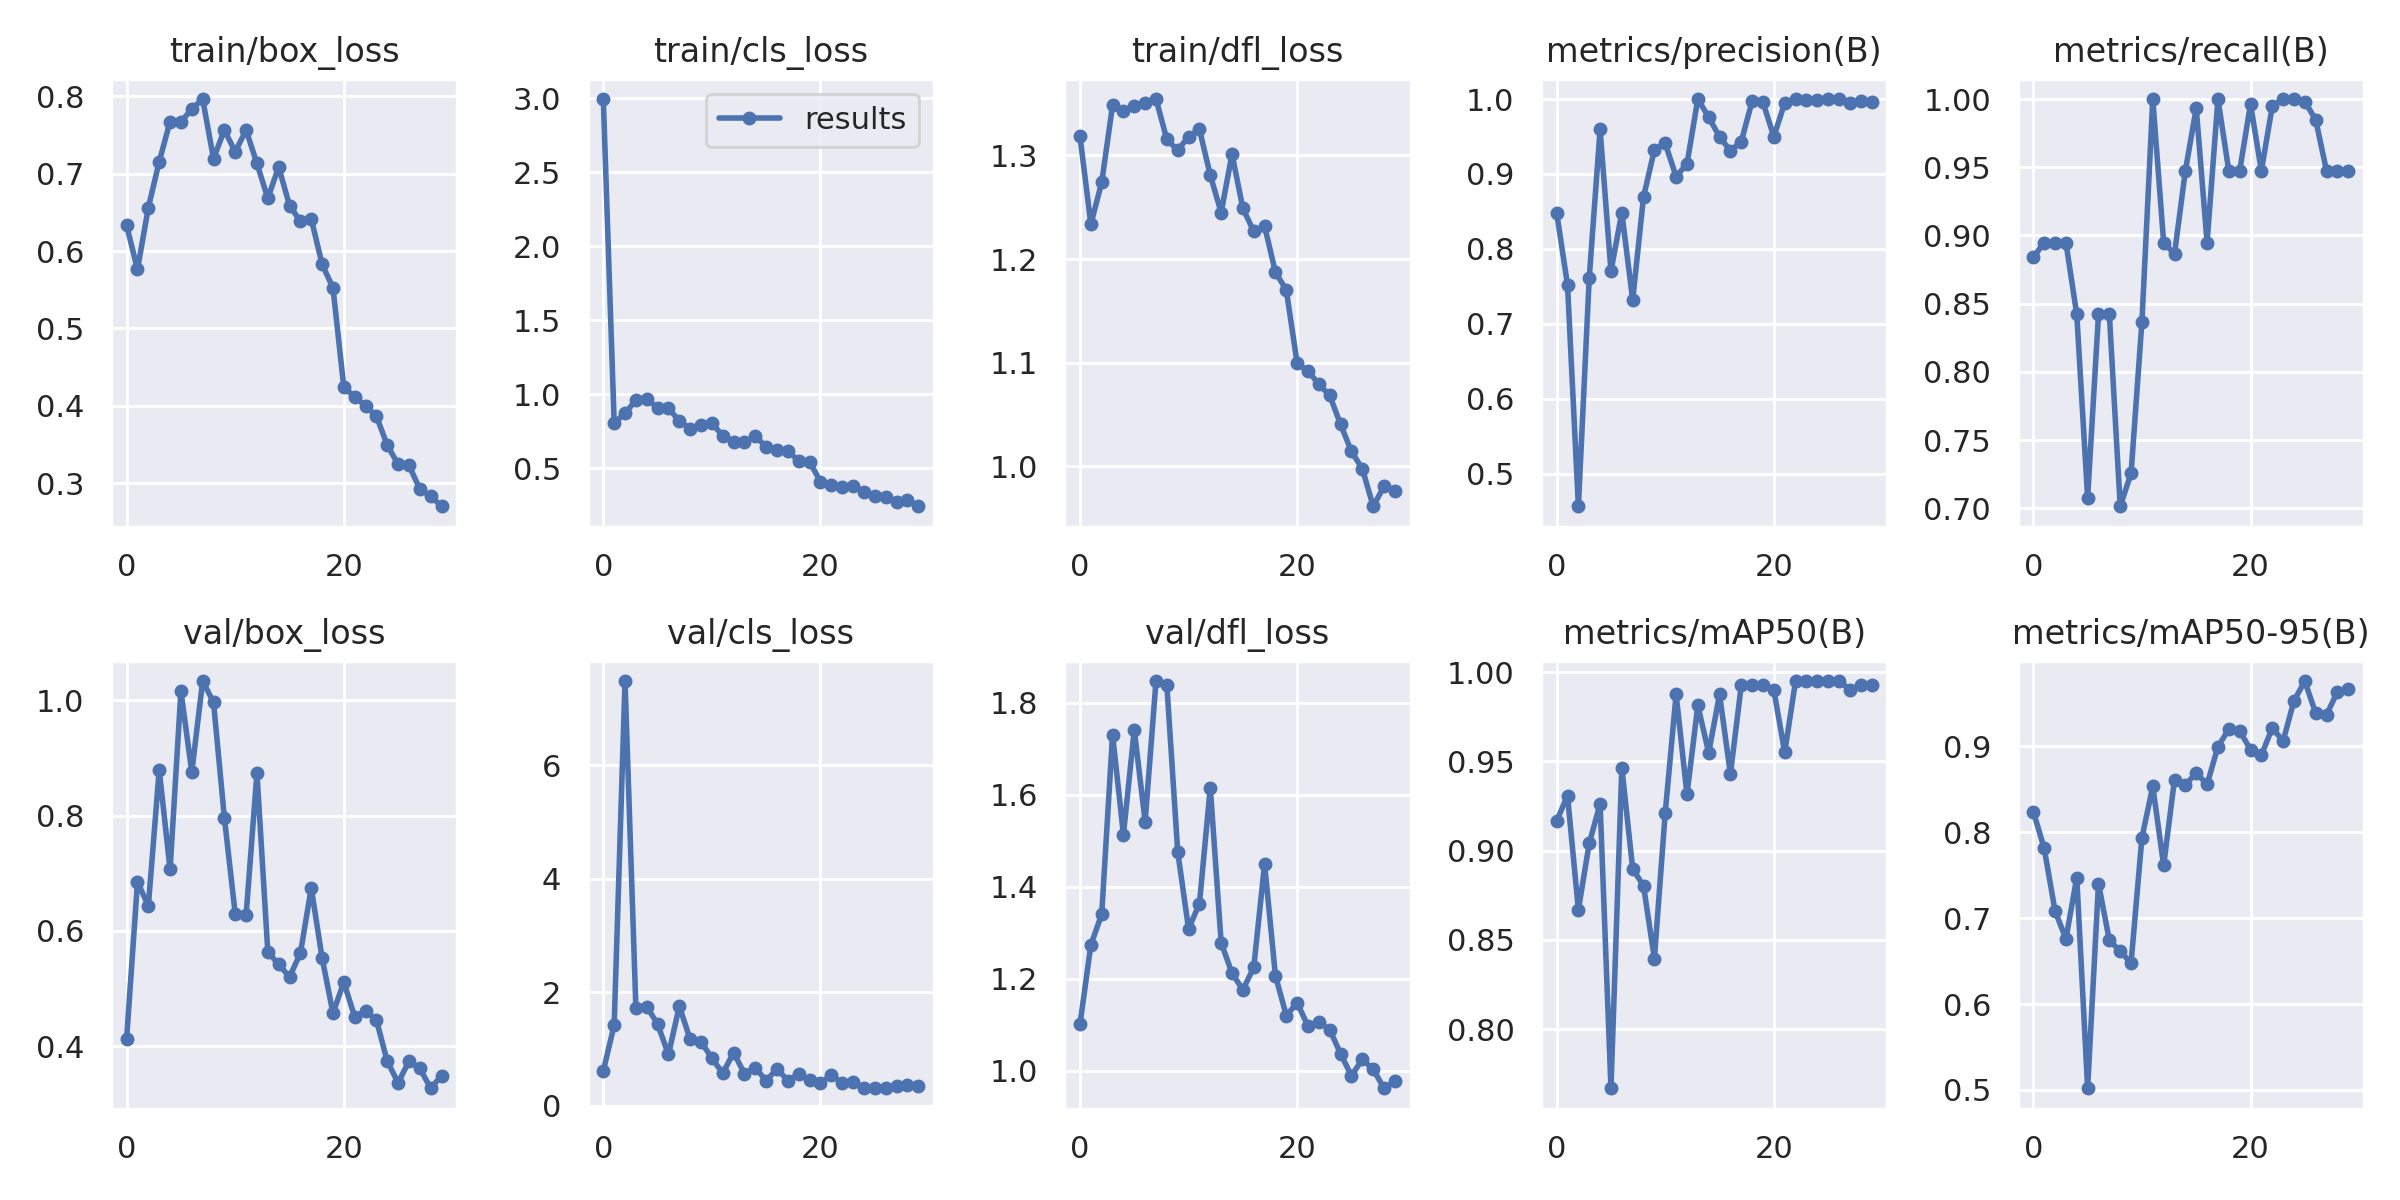

In [8]:
Image(filename='./runs/detect/train/results.png', width=600)

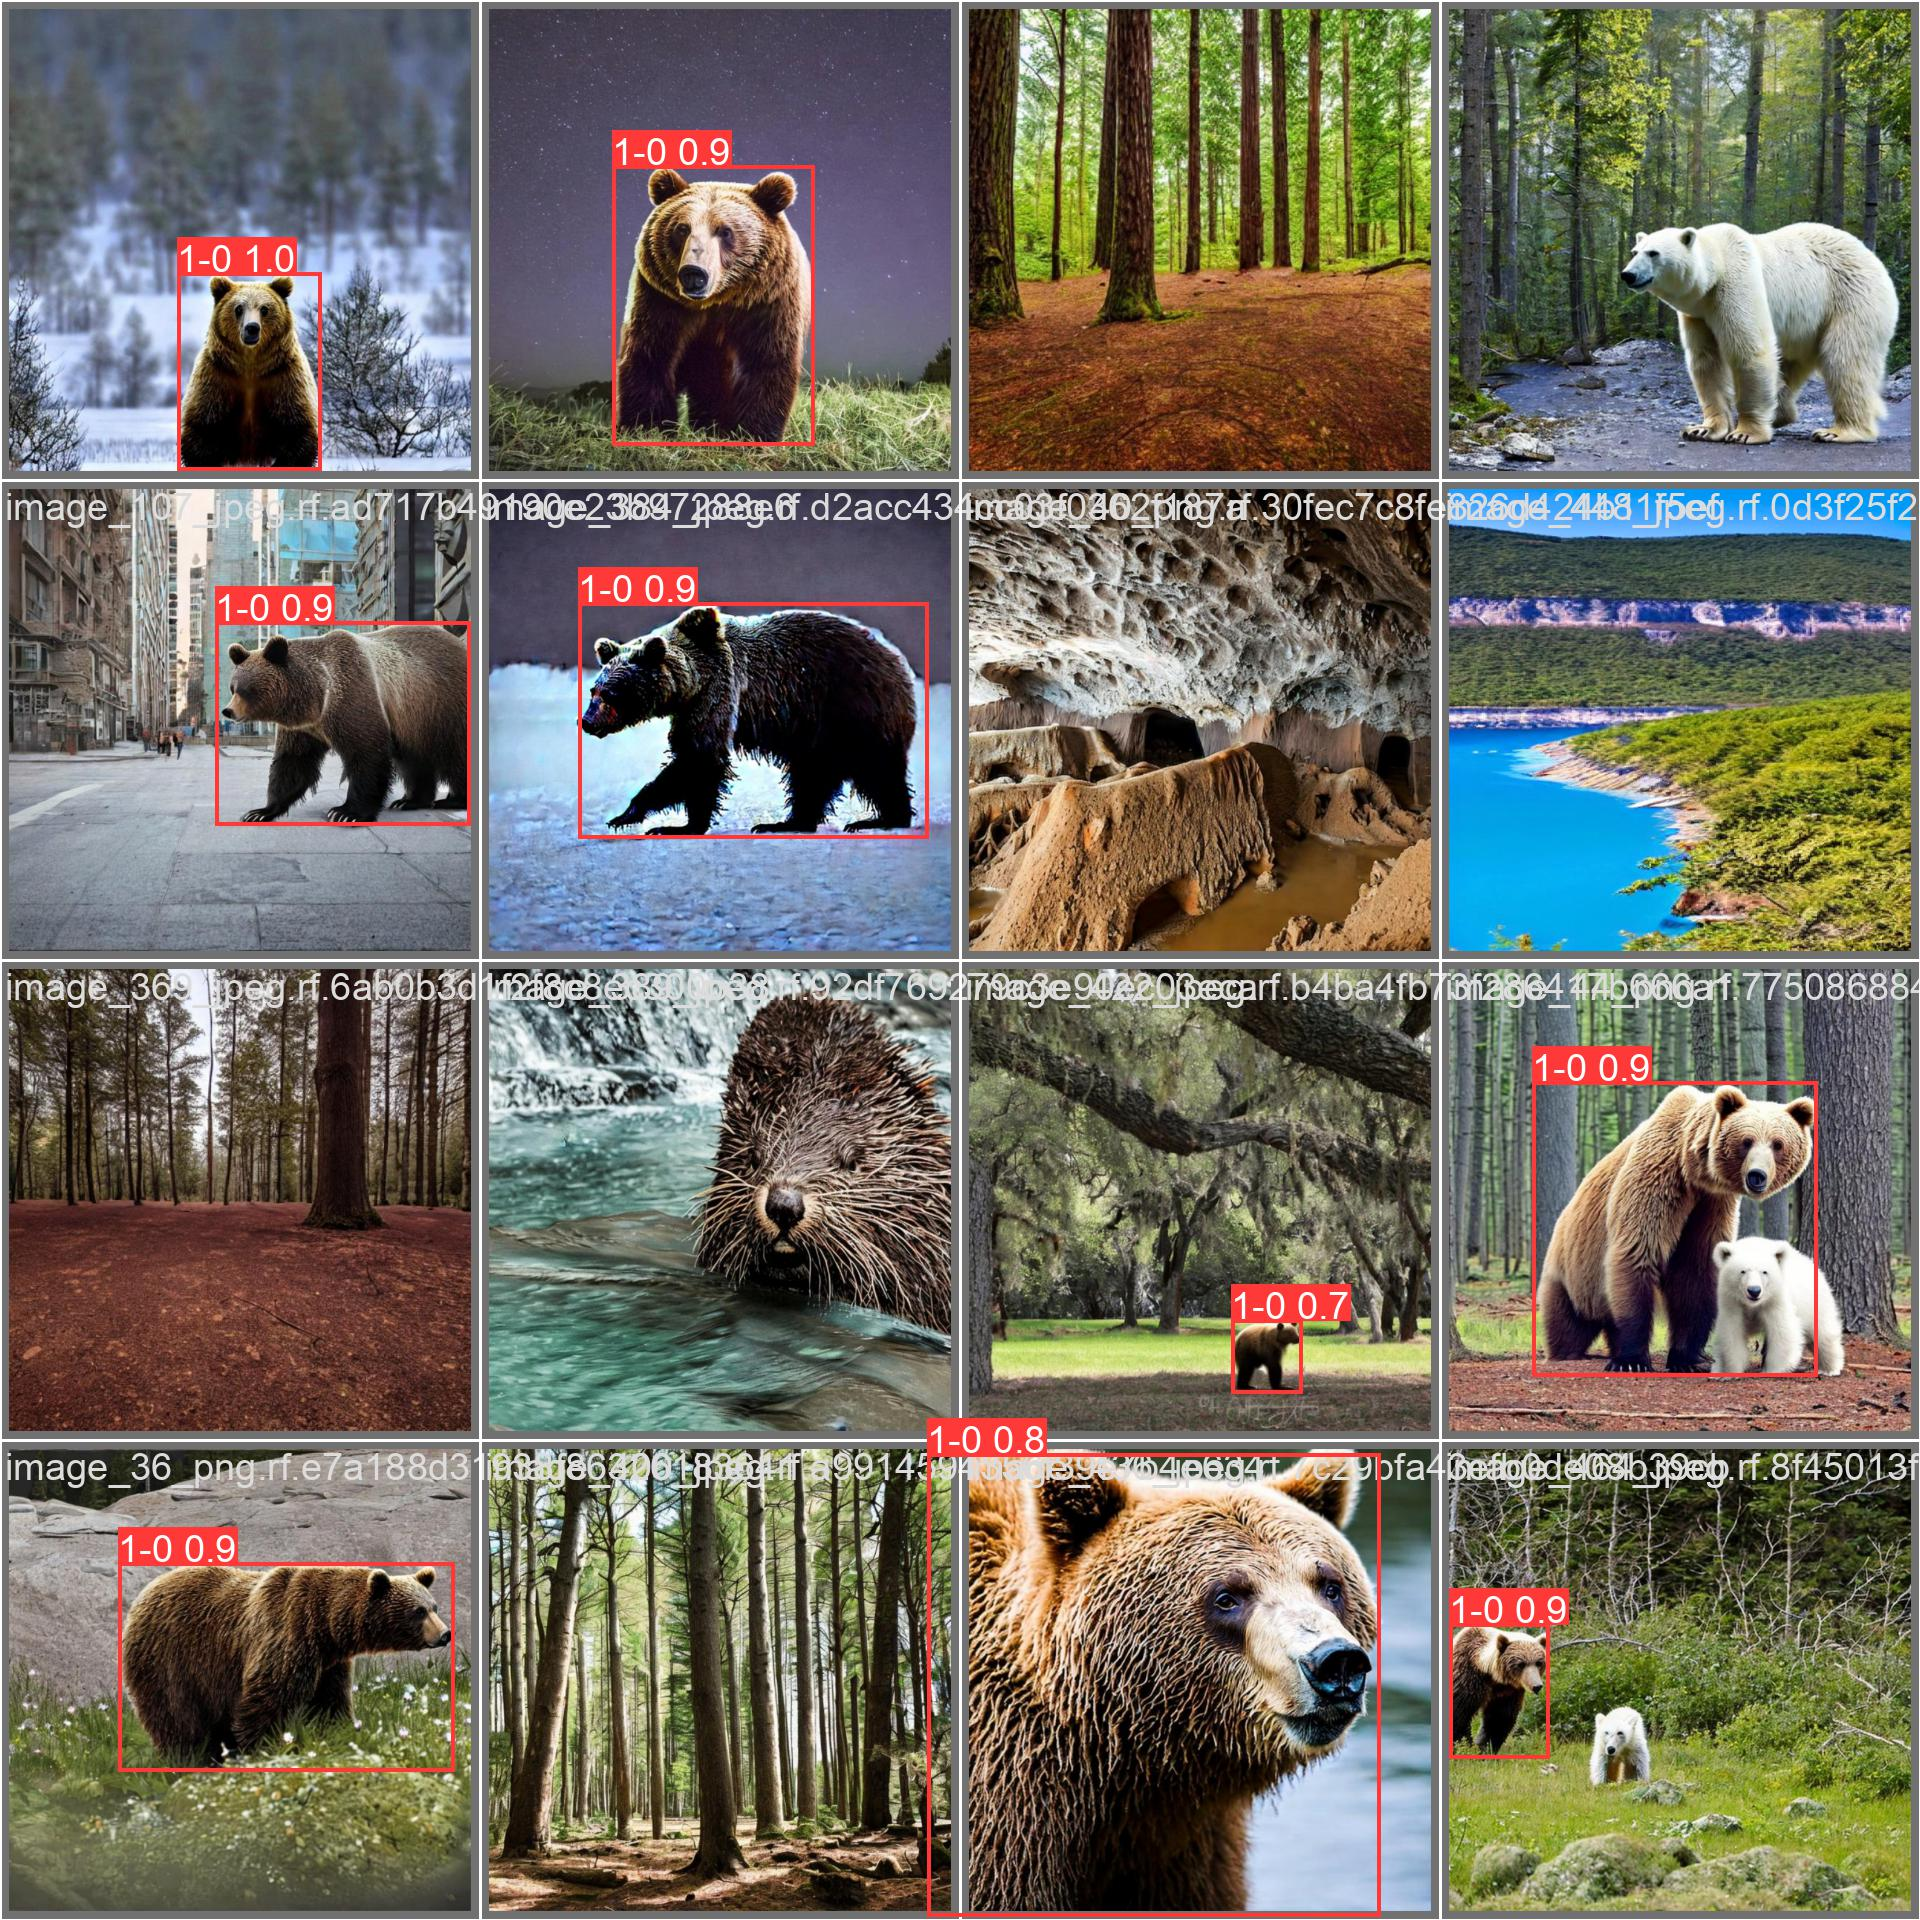

In [9]:
Image(filename=f'./runs/detect/train/val_batch0_pred.jpg', width=600)

Finally evaluate on test data.

In [11]:
!yolo task=detect mode=val model=./runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/Bears-2/test/labels... 29 images, 20 backgrounds, 0 corrupt: 100% 29/29 [00:00<00:00, 473.07it/s]
val: New cache created: /content/datasets/Bears-2/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.31it/s]
                   all         29          9          1      0.994      0.995      0.871
Speed: 0.3ms pre-process, 19.5ms inference, 0.0ms loss, 0.9ms post-process per image


# Training the Final model

While experementing I tried different model parameters and configurations of dataset.

After the best configuration was found I decreased test part of the data to zero and trained the best model on the big training set with 15% validation part.

In [ ]:
drive.mount('/content/drive')

!mkdir ./datasets
%cd ./datasets

# Dowloading the 3-rd version of dataset without testing part.
rf = Roboflow(api_key="SeScyFeiR90djceO280o")
project = rf.workspace("aml-92lrc").project("bears-8v0yh")
dataset = project.version(3).download("yolov8")

Mounted at /content/drive
/content/datasets
loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Bears-3 in yolov8:: 100%|██████████| 2167/2167 [00:01<00:00, 1806.15it/s]


In [ ]:
!yolo task=detect mode=train model=../drive/MyDrive/Training/kontur_2023/last.pt data={dataset.location}/data.yaml epochs=60 imgsz=800 plots=True

Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/Bears-3/data.yaml, epochs=60, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=

Let's save trained weights on the disk.

In [ ]:
!cp -i "./runs/detect/train/weights/last.pt" "../drive/MyDrive/Training/kontur_2023/models"

# Prediction

One of the ideas was to use an ensemble of two models. First one is fine tuned `Inception from Torchvision` which will classify whether there is a bear on the image and if it is then `YOLOv8` will make the prediction.

This idea did not show the best result, `YOLO` by itself worked better but here I left the code with `Inception` to show how it suposed to work.

In [2]:
num_classes = 2
inception_model, input_size = initialize_inception_model(num_classes)
inception_model.load_state_dict(torch.load('./drive/MyDrive/Training/kontur_2023/models/best_inception.pt', map_location=device))

yolo_model = YOLO("./drive/MyDrive/Training/kontur_2023/models/last.pt")

Inception model was loaded sucessfully.


In [ ]:
df = pd.read_csv('./drive/MyDrive/Training/kontur_2023/test.csv')

x1, y1, x2, y2 = [], [], [], []
confidence = []

for index, row in df.iterrows():
    filename = row['file_name']
    path = "./drive/MyDrive/Training/kontur_2023/bear_images/" + filename

    # Inception checks whether the image contains a bear or not.
    pred = predict_sample(inception_model, input_size, path)

    # Make a prediction with YOLO if image contatins a brwn bear.
    img = cv2.imread(path)
    outputs = yolo_model.predict(source=img)
    outputs = [output.cpu().numpy() for output in outputs]

    # If pred == 0 this is menas that inception model did not find bear on the
    #   image and predictions for this sample are equal to zero. 
    if pred == 0 or len(outputs[0].boxes.xyxy) == 0:
        x_1, y_1, x_2, y_2 = 0, 0, 0, 0
        conf = 0
    else:
        confidences = [out.boxes.conf[0] for out in outputs]
        best = outputs[np.argmax(confidences)]
        x_1, y_1, x_2, y_2 = best.boxes.xyxy[0]
        conf = best.boxes.conf[0]

    x1.append(x_1)
    y1.append(y_1)
    x2.append(x_2)
    y2.append(y_2)
    confidence.append(conf)

df['x1'], df['y1'], df['x2'], df['y2'] = x1, y1, x2, y2
df['confidence'] = confidence

df.to_csv('./drive/MyDrive/Training/kontur_2023/prediction9.csv', index=False)
df

Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


,file_name,x1,y1,x2,y2,confidence
0,image_101.jpeg,147.0,314.0,477.0,550.0,0.943948
1,image_108.jpeg,253.0,533.0,419.0,631.0,0.883644
2,image_109.png,0.0,0.0,0.0,0.0,0.000000
3,image_10.jpeg,0.0,0.0,0.0,0.0,0.000000
4,image_110.jpeg,590.0,273.0,706.0,514.0,0.739934
...,...,...,...,...,...,...
144,image_85.jpeg,0.0,0.0,0.0,0.0,0.000000
145,image_91.png,0.0,0.0,0.0,0.0,0.000000
146,image_92.jpeg,0.0,0.0,0.0,0.0,0.000000
147,image_94.jpeg,0.0,0.0,0.0,0.0,0.000000
